# Python-Oracle Anbindung

## Benötigte Pakete:

   
    - Oracle-Pandas: 'pip install pandas-oracle', https://github.com/cwade/pandas_oracle
    - cx_Oracle: siehe unten
    - Seaborn, Pandas, Numpy, etc 


## Anleitung: 

- Installiert `cx_Oracle`
- Ladet den Oracle Instant Client herunter:
https://www.oracle.com/database/technologies/instant-client/downloads.html
- Führt die entsprechenden Installationsanweisungen durch

In [1]:
# Bei Bedarf auskommentieren
!python -m pip install cx_Oracle --upgrade
!python -m pip install pandas-oracle

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for cx_Oracle: filename=cx_Oracle-8.3.0-cp311-cp311-macosx_11_0_arm64.whl size=157032 sha256=6c00994f2278c3b0d6e73f5a5550e9388009879d9c133ae69de93ca531bda76f
  Stored in directory: /Users/luhangfang/Library/Caches/pip/wheels/e0/41/f9/63e9c4d1ec7b2e8faffc1d6f3219c2e168c306b042d77e2b6f
Successfully built cx_Oracle
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-oracle: filename=pandas_oracle-2.1.4-py3-none-any.whl size=4021 sha256=2f4c77836a7fea82c6c5a3d11e6164d13186c5e777a5af1ba6088c5438cf90ae
  Stored in directory: /Users/luhangfang/Library/Caches/pip/wheels/40/10/d8/77fcd34bebe434048462d124a3c014b6a68e31a9409e78a533
Successfully built pandas-oracle


## Pfad setzen

In [1]:
import cx_Oracle 

# Pfad anpassen!!
path_to_instant_client = "/Users/luhangfang/Documents/Software/instantclient_23_3"
try:
    cx_Oracle.init_oracle_client(lib_dir=path_to_instant_client)
except cx_Oracle.ProgrammingError as e:
    if "already been initialized" not in str(e):
        raise    

: 

## HU-VPN  aktivieren oder in HU-Netzwerk (WLAN) einloggen.

Anleitungen:
https://www.cms.hu-berlin.de/de/dl/netze/vpn


## Verbindungsdaten: 
Die Verbindungsdaten werden in `config.yml` gespeichert. Die Datein *muss* im gleichen Ordner liegen.

In [105]:
import cx_Oracle

import pandas_oracle.tools as pt
import numpy as np
import pandas as pd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium import plugins

## Verbindungsaufbau:

In [3]:
def run_query(query) :
    ## opening conn
    conn = pt.open_connection("config.yml")

    try:
        ## passing the conn object to the query_to_df
        df1 = pt.query_to_df(query, conn, 10000)
        return df1
    except Exception as e:
        print("An exception occurred")
        print(str(e))
    finally:
        ## close connection
        pt.close_connection(conn)

*Wichtig: die Verbindungs zur DB muss geschlossen werden, wenn ein Fehler auftritt.*

# 1. Beispielanfrage

In [4]:
query = "select * from airport"
df = run_query(query)
df

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,EGE,Eagle County Regional Airport,Eagle,CO,USA,3964257.0,-10691770.0
1,EKO,Elko Regional Airport,Elko,NV,USA,4082493.0,-11579170.0
2,ELM,Elmira/Corning Regional Airport,Elmira,NY,USA,4215991.0,-7689144.0
3,ELP,El Paso International Airport,El Paso,TX,USA,3180667.0,-10637781.0
4,ERI,Erie International Airport,Erie,PA,USA,4208202.0,-8017622.0
...,...,...,...,...,...,...,...
317,EAU,Chippewa Valley Regional Airport,Eau Claire,WI,USA,4486526.0,-9148507.0
318,ECP,Northwest Florida Beaches International Airport,Panama City,FL,USA,NaN,NaN
319,PBG,Plattsburgh International Airport,Plattsburgh,NY,USA,NaN,NaN
320,UST,Northeast Florida Regional Airport (St. August...,St. Augustine,FL,USA,NaN,NaN


## Visualisierung

In [9]:
df.columns

Index(['DELAY_CATEGORY', 'TOTAL_MINUTES', 'PERCENTAGE'], dtype='object')

In [10]:
# Vorsicht: hier wird aggregiert. Das wollen wir aber selbst in SQL machen!
# Siehe nächste Anfrage
g=sns.catplot(x='STATE',
            kind='count',
            height=4, 
            aspect=4.5,
            data=df,
            order=df['STATE'].value_counts().index)
_=g.set_xticklabels(rotation=90)

KeyError: 'STATE'

# 2. Beispielanfrage

In [11]:
query2 = "select state, count(*) as anz from airport GROUP BY STATE"
df = run_query(query2)
df.head()

,STATE,ANZ
0,NJ,3
1,AK,19
2,SD,3
3,MN,8
4,OK,3


## Visualisierung

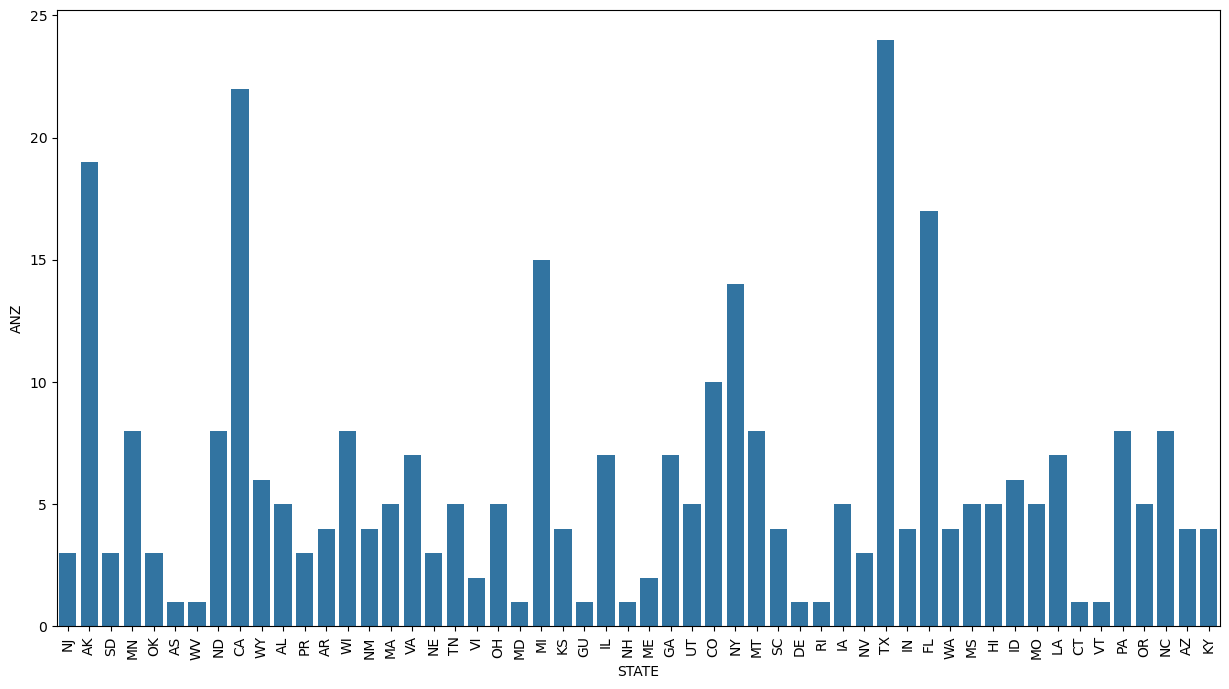

In [12]:
plt.figure(figsize=(15,8))
ax=sns.barplot(x='STATE',
            y='ANZ',
            data=df)

tick_positions = ax.get_xticks()
ax.set_xticks(tick_positions)
_=ax.set_xticklabels(df['STATE'], rotation=90)
plt.show()

## 3. EXPLAIN PLAN

In [ ]:
def explain_plan_query(query) :
    ## opening conn
    conn = pt.open_connection("config.yml")
    try:
        # There is small change 
        #  ("+query+")" => " + query
        # query_explain = "EXPLAIN PLAN FOR ("+query+")"
        query_explain = "EXPLAIN PLAN FOR " + query
        pt.execute(query_explain, conn)        
        query2 = "SELECT PLAN_TABLE_OUTPUT FROM TABLE(DBMS_XPLAN.DISPLAY())"
        
        df = pt.query_to_df(query2, conn, 10000)
        return df
    except Exception as e:
        print("An exception occurred:", str(e))
    finally:
        ## close connection
        pt.close_connection(conn)

In [87]:
query = "SELECT * FROM delays"
df = explain_plan_query(query)

print(df.to_string())

                                                              PLAN_TABLE_OUTPUT
0                                                   Plan hash value: 3893133417
1                                                                              
2  ----------------------------------------------------------------------------
3  | Id  | Operation         | Name   | Rows  | Bytes | Cost (%CPU)| Time     |
4  ----------------------------------------------------------------------------
5  |   0 | SELECT STATEMENT  |        |  5332K|   472M| 22662   (2)| 00:00:01 |
6  |   1 |  TABLE ACCESS FULL| DELAYS |  5332K|   472M| 22662   (2)| 00:00:01 |
7  ----------------------------------------------------------------------------


#### 3.1 Ursache der Verspätung

##### 3.1.1 SQL

In [89]:
query1_1 = """
SELECT 
    CASE 
        WHEN delay_type = 'air_system_delay' THEN 'Air System Delay'
        WHEN delay_type = 'security_delay' THEN 'Security Delay'
        WHEN delay_type = 'airline_delay' THEN 'Airline Delay'
        WHEN delay_type = 'late_aircraft_delay' THEN 'Late Aircraft Delay'
        WHEN delay_type = 'weather_delay' THEN 'Weather Delay'
    END as delay_category,
    SUM(delay_minutes) as total_minutes,
    ROUND(SUM(delay_minutes) * 100.0 / SUM(SUM(delay_minutes)) OVER (), 2) as percentage
FROM (
    SELECT 'air_system_delay' as delay_type, COALESCE(air_system_delay, 0) as delay_minutes FROM delays
    UNION ALL
    SELECT 'security_delay', COALESCE(security_delay, 0) FROM delays
    UNION ALL
    SELECT 'airline_delay', COALESCE(airline_delay, 0) FROM delays
    UNION ALL
    SELECT 'late_aircraft_delay', COALESCE(late_aircraft_delay, 0) FROM delays
    UNION ALL
    SELECT 'weather_delay', COALESCE(weather_delay, 0) FROM delays
) unpivoted
GROUP BY delay_type
HAVING SUM(delay_minutes) > 0
ORDER BY total_minutes DESC
"""
df1_1 = run_query(query1_1)
df1_1

,DELAY_CATEGORY,TOTAL_MINUTES,PERCENTAGE
0,Late Aircraft Delay,23767674,40.06
1,Airline Delay,18966945,31.96
2,Air System Delay,13533065,22.81
3,Weather Delay,2991008,5.04
4,Security Delay,77945,0.13


##### 3.1.2 Visualisierung

![1](./1.png)

#### 3.1.3 EXPLAIN PLAN und Indices

In [91]:
query1_2 = """
CREATE INDEX idx_delay_facts_delays ON delays (
    air_system_delay,
    security_delay,
    airline_delay,
    late_aircraft_delay,
    weather_delay
)
"""


df1_3 = explain_plan_query(query1_1)
print(df1_3.to_string())

                                                                    PLAN_TABLE_OUTPUT
0                                                         Plan hash value: 3851689523
1                                                                                    
2   ---------------------------------------------------------------------------------
3   | Id  | Operation              | Name   | Rows  | Bytes | Cost (%CPU)| Time     |
4   ---------------------------------------------------------------------------------
5   |   0 | SELECT STATEMENT       |        |    26M|   610M|   115K  (4)| 00:00:05 |
6   |   1 |  WINDOW SORT           |        |    26M|   610M|   115K  (4)| 00:00:05 |
7   |*  2 |   FILTER               |        |       |       |            |          |
8   |   3 |    HASH GROUP BY       |        |    26M|   610M|   115K  (4)| 00:00:05 |
9   |   4 |     VIEW               |        |    26M|   610M|   113K  (2)| 00:00:05 |
10  |   5 |      UNION-ALL         |        |       | 

### 3.2 Analyse:Region

#### 3.2.1 SQL

In [94]:
query2_1 ="""
SELECT 
    f.origin_state as STATE,
    f.origin_airport as AIRPORT,
    f.origin_city as City,
    f.origin_latitude/100000.0 as LATITUDE,  
    f.origin_longitude/100000.0 as LONGITUDE,  
    COUNT(*) as TOTAL_FLIGHTS,
    SUM(CASE WHEN d.departure_delay > 0 THEN 1 ELSE 0 END) as DELAYED_FLIGHTS,
    ROUND(SUM(CASE WHEN d.departure_delay > 0 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) as DELAY_PERCENTAGE,
    ROUND(AVG(CASE WHEN d.departure_delay > 0 THEN d.departure_delay ELSE NULL END), 2) as AVG_DELAY_MINUTES
FROM Flight f
JOIN Delays d ON f.flight_id = d.flight_id
GROUP BY 
    f.origin_state,
    f.origin_airport,
    f.origin_city,
    f.origin_latitude,
    f.origin_longitude
HAVING COUNT(*) > 100;
"""
df2_1 = run_query(query2_1)
df2_1

,STATE,AIRPORT,TOTAL_FLIGHTS,DELAYED_FLIGHTS,DELAY_PERCENTAGE,AVG_DELAY_MINUTES
0,GU,Guam International Airport,334,226,67.66,26.80
1,MA,Martha's Vineyard Airport,205,111,54.15,51.58
2,TX,Dallas Love Field,59699,30925,51.80,25.48
3,IL,Chicago Midway International Airport,80886,40879,50.54,27.71
4,MD,Baltimore-Washington International Airport,86079,41866,48.64,30.53
...,...,...,...,...,...,...
309,ID,Pocatello Regional Airport,654,72,11.01,56.92
310,ID,Lewiston-Nez Perce County Airport,588,54,9.18,27.70
311,NV,Elko Regional Airport,531,47,8.85,49.94
312,UT,Canyonlands Field,206,11,5.34,23.91


#### 3.2.2 Visualisierung

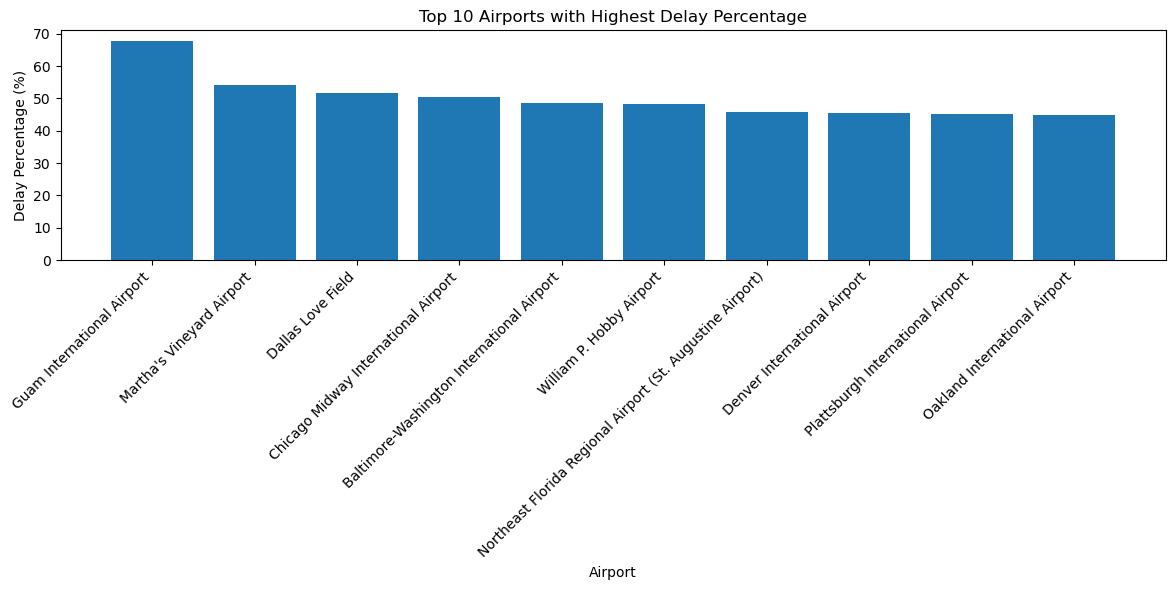

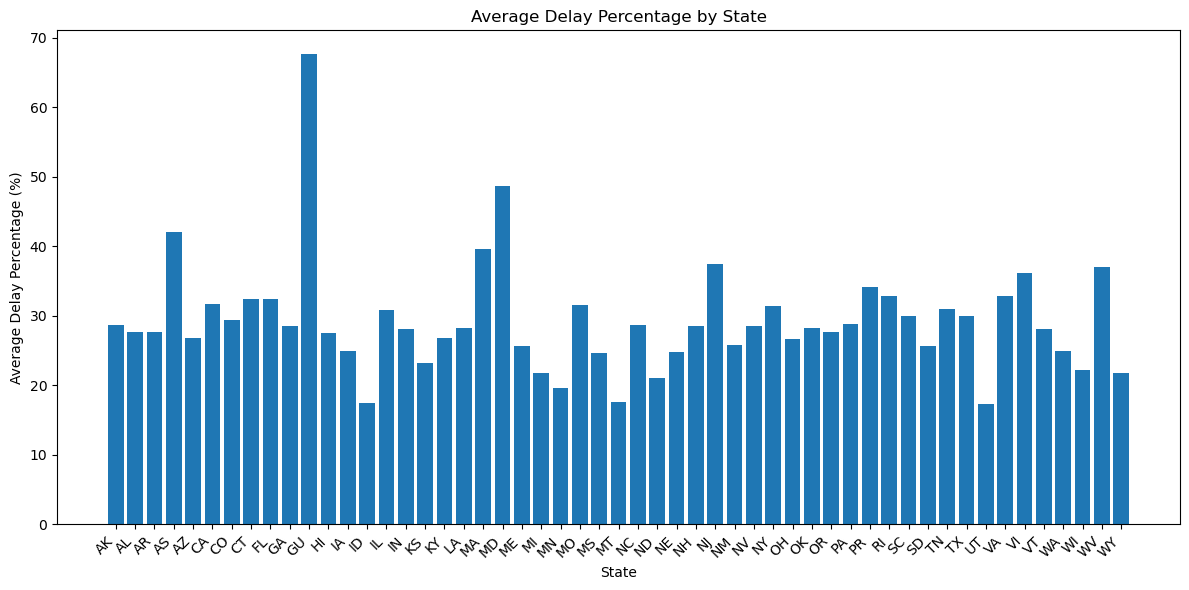

In [99]:
import seaborn as sns

def plot_region(df):
    # Convert uppercase to lowercase
    df.columns = df.columns.str.lower()

    # Create bar plot for top 10 states/airports
    plt.figure(figsize=(12, 6))
    plt.bar(df['airport'][:10], df['delay_percentage'][:10])
    plt.xticks(rotation=45, ha='right')
    plt.title('Top 10 Airports with Highest Delay Percentage')
    plt.xlabel('Airport')
    plt.ylabel('Delay Percentage (%)')
    plt.tight_layout()
    plt.show()

    # Create heatmap by state
    state_delays = df.groupby('state')['delay_percentage'].mean().reset_index()
    plt.figure(figsize=(12, 6))
    plt.bar(state_delays['state'], state_delays['delay_percentage'])
    plt.xticks(rotation=45, ha='right')
    plt.title('Average Delay Percentage by State')
    plt.xlabel('State')
    plt.ylabel('Average Delay Percentage (%)')
    plt.tight_layout()
    plt.show()

plot_region(df2_1)

In [100]:
quera2_2 = """
-- Delay_Facts table indices
CREATE INDEX idx_delay_facts_flight ON Delay_Facts(flight_id);
CREATE INDEX idx_delay_facts_time ON Delay_Facts(year, month, day);
CREATE INDEX idx_delay_facts_delays ON Delay_Facts(
    departure_delay,
    air_system_delay,
    security_delay,
    airline_delay,
    late_aircraft_delay,
    weather_delay
);

-- Flight table indices
CREATE INDEX idx_flight_airports ON Flight(
    origin_airport,
    destination_airport
);
CREATE INDEX idx_flight_location ON Flight(
    origin_airport_state,
    origin_airport_city,
    origin_latitude,
    origin_longitude
);
CREATE INDEX idx_flight_schedule ON Flight(
    Scheduled_Time,
    Scheduled_Departure,
    Scheduled_Arrival
);

-- Time table indices
CREATE INDEX idx_time_date ON Time(Year, Month, Day);

-- Airline table index
CREATE INDEX idx_airline_code ON Airline(IATA_CODE);
"""

df2_3 = explain_plan_query(query2_1)
print(df2_3.to_string())

                                                                           PLAN_TABLE_OUTPUT
0                                                                Plan hash value: 1826321713
1                                                                                           
2   ----------------------------------------------------------------------------------------
3   | Id  | Operation             | Name   | Rows  | Bytes |TempSpc| Cost (%CPU)| Time     |
4   ----------------------------------------------------------------------------------------
5   |   0 | SELECT STATEMENT      |        |    17 |   935 |       | 33483   (4)| 00:00:02 |
6   |   1 |  SORT ORDER BY        |        |    17 |   935 |       | 33483   (4)| 00:00:02 |
7   |*  2 |   FILTER              |        |       |       |       |            |          |
8   |   3 |    HASH GROUP BY      |        |    17 |   935 |       | 33483   (4)| 00:00:02 |
9   |*  4 |     HASH JOIN         |        |  5264K|   276M|    27M| 3

### 3.3 Analyse:Weather

#### 3.3.1 SQL

In [101]:
# Query 1: Top 10 days with most weather-related cancellations
query3_1 = """
SELECT 
    f.year,
    f.month,
    f.day,
    COUNT(*) as weather_cancellations,
    COUNT(*) * 100.0 / SUM(COUNT(*)) OVER () as percentage_of_total
FROM Delays f
WHERE f.cancelled = 1 
AND f.cancellation_reason = 'B'  -- B represents Weather cancellations
GROUP BY f.year, f.month, f.day
ORDER BY weather_cancellations DESC
FETCH FIRST 10 ROWS ONLY
"""
df3_1 = run_query(query3_1)
df3_1

,YEAR,MONTH,DAY,WEATHER_CANCELLATIONS,PERCENTAGE_OF_TOTAL
0,2015,1,27,2513,5.249196
1,2015,3,5,2161,4.513932
2,2015,2,2,2025,4.229853
3,2015,12,28,1831,3.824623
4,2015,2,1,1527,3.189623
5,2015,3,1,1289,2.692484
6,2015,1,26,1288,2.690396
7,2015,2,15,1138,2.377073
8,2015,2,23,1130,2.360363
9,2015,2,28,1029,2.149392


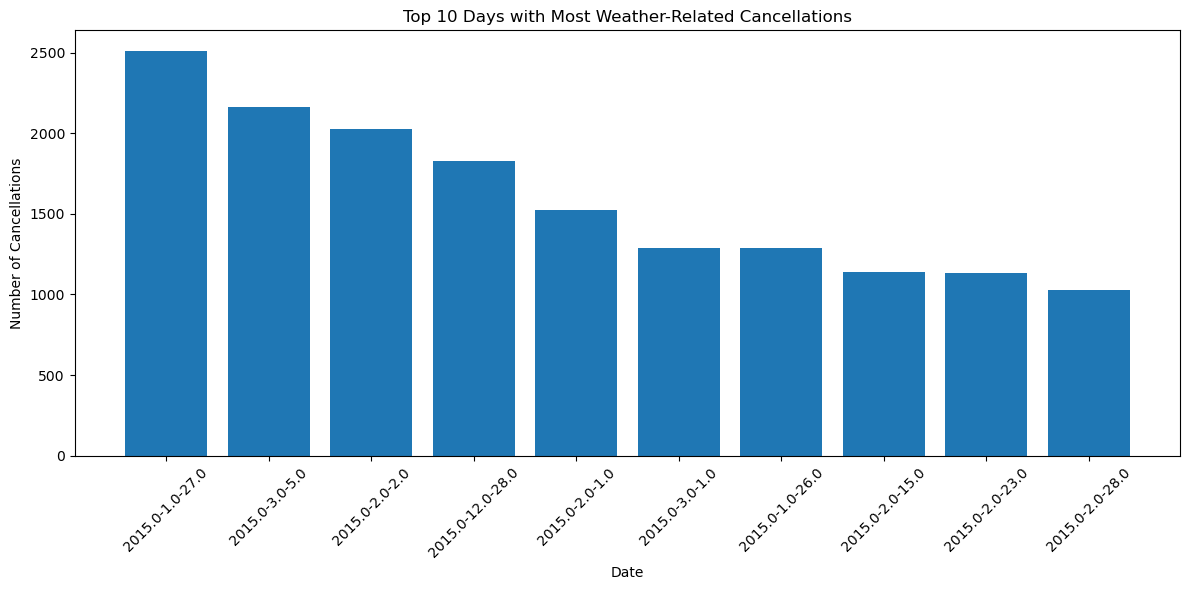

In [107]:

# For the top 10 days
def plot_top_days(df_days):
    # Convert uppercase to lowercase
    df_days.columns = df_days.columns.str.lower()
    plt.figure(figsize=(12, 6))
    dates = [f"{row['year']}-{row['month']}-{row['day']}" for _, row in df_days.iterrows()]
    plt.bar(dates, df_days['weather_cancellations'])
    plt.xticks(rotation=45)
    plt.title('Top 10 Days with Most Weather-Related Cancellations')
    plt.xlabel('Date')
    plt.ylabel('Number of Cancellations')
    plt.tight_layout()
    plt.show()

plot_top_days(df3_1)

In [104]:
# Query 2: Airports with most weather-related cancellations
query3_2 = """
SELECT 
    f.origin_airport,
    fl.origin_city,
    fl.origin_state,
    COUNT(*) as total_weather_cancellations,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) as percentage_of_total,
    fl.origin_latitude,
    fl.origin_longitude
FROM Delays f
JOIN Flight fl ON f.flight_id = fl.flight_id
WHERE f.cancelled = 1 
AND f.cancellation_reason = 'B'
GROUP BY f.origin_airport, fl.origin_city, fl.origin_state, 
         fl.origin_latitude, fl.origin_longitude
ORDER BY total_weather_cancellations DESC
"""
df3_2 = run_query(query3_2)
df3_2


,ORIGIN_AIRPORT,ORIGIN_CITY,ORIGIN_STATE,TOTAL_WEATHER_CANCELLATIONS,PERCENTAGE_OF_TOTAL,ORIGIN_LATITUDE,ORIGIN_LONGITUDE
0,ORD,Chicago,IL,4769,9.96,4197960.0,-8790446.0
1,DFW,Dallas-Fort Worth,TX,4664,9.74,3289595.0,-9703720.0
2,LGA,New York,NY,2191,4.58,4077724.0,-7387261.0
3,BOS,Boston,MA,1882,3.93,4236435.0,-7100518.0
4,ATL,Atlanta,GA,1707,3.57,3364044.0,-8442694.0
...,...,...,...,...,...,...,...
306,BLI,Bellingham,WA,1,0.00,4879275.0,-12253753.0
307,CDC,Cedar City,UT,1,0.00,3770097.0,-11309858.0
308,ITH,Ithaca,NY,1,0.00,4249103.0,-7645844.0
309,LIH,Lihue,HI,1,0.00,2197598.0,-15933896.0


In [ ]:
def convert_coordinates(value):
    """Convert 7-digit coordinates to decimal degrees"""
    return float(value) / 1000000

# For the airport map
def create_airport_map(df_airports):
    # Convert uppercase to lowercase
    df_airports.columns = df_airports.columns.str.lower()
    # Drop rows with missing latitude and longitude
    df_clean = df_airports.dropna(subset=['origin_latitude', 'origin_longitude'])
    m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)
    
    # Add markers for each airport
    for idx, row in df_clean.iterrows():
        # Convert coordinates
        lat = convert_coordinates(row['origin_latitude'])
        lon = convert_coordinates(row['origin_longitude'])

        # Calculate marker size based on cancellation percentage
        radius = row['percentage_of_total'] * 2
        
        popup_text = f"""
        Airport: {row['origin_airport']}<br>
        City: {row['origin_city']}<br>
        State: {row['origin_state']}<br>
        Weather Cancellations: {row['total_weather_cancellations']}<br>
        Percentage: {row['percentage_of_total']}%
        """
        
        folium.CircleMarker(
            location=[lat, lon],
            radius=radius,
            popup=popup_text,
            color='blue',
            fill=True,
            fill_opacity=0.6
        ).add_to(m)
    
    # # Add heatmap layer
    # heat_data = df_clean[[convert_coordinates(row['origin_latitude']), 
    #              convert_coordinates(row['origin_longitude']), 
    #              'total_weather_cancellations']].values.tolist()
    # plugins.HeatMap(heat_data).add_to(m)

    # new way of heat map, bno error but dont show up
    heat_data = []
    for idx, row in df_clean.iterrows():
        lat = convert_coordinates(row['origin_latitude'])
        lon = convert_coordinates(row['origin_longitude'])
        heat_data.append([lat, lon, row['total_weather_cancellations']])
    plugins.HeatMap(heat_data).add_to(m)
    return m

create_airport_map(df3_2)